## Importing the Libraries

The first step is to import the libraries required to preprocess Mosaic24 stock data and the other libraries required for constructing and visualizing the LSTM model outputs. We’ll be using the Keras library from the TensorFlow framework for this. All modules are imported from the Keras library.

In [77]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils import plot_model
import seaborn as sns

## Getting to Visualising the Stock Market Prediction Data

Using the Pandas Data Reader library, we will upload the stock data from the local system as a Comma Separated Value (.csv) file and save it to a pandas DataFrame. Finally, we will examine the data.

In [78]:
# Importing the data
df = pd.read_csv("data/train.csv",index_col="Date",parse_dates=True,infer_datetime_format=True)
df.head()

C:\Users\alaza\AppData\Local\Temp\ipykernel_14796\2734896154.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("data/train.csv",index_col="Date",parse_dates=True,infer_datetime_format=True)


,Id,Open,High,Low,Close,Adj Close,Volume,Company
Date,,,,,,,,
2033-03-01,0,159.271109,167.221488,157.380478,161.915062,160.167043,40490589,Company_0
2033-03-01,1,114.571843,114.409664,112.921505,113.066659,87.844722,8592865,Company_1
2033-03-01,2,50.984499,51.262529,50.266272,50.094499,49.329834,25085661,Company_2
2033-03-01,3,98.585428,99.988079,97.867719,98.811966,91.784469,823271,Company_3
2033-03-01,4,8874.646107,8935.704765,8811.247764,8873.173069,8407.389386,609369,Company_4


## Checking for Null Values

We’ll check for null values in the data frame to ensure that there are none. The existence of null values in the dataset causes issues during training since they function as outliers

In [79]:
# checking for null values
df.isna().sum()

Id           0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Company      0
dtype: int64

In [80]:
#  check for duplicated data
df.duplicated().sum()

0

##  Plotting the True Close Value

The Close Value is the final output value that will be forecasted using the Machine Learning model. This figure indicates the stock’s closing price on that particular day of stock market trading.

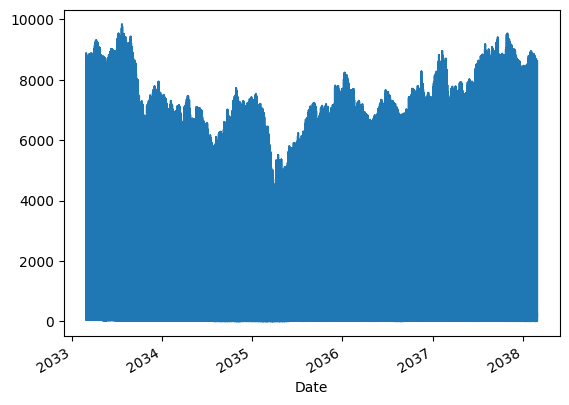

In [81]:
df["Close"].plot(kind="line");

## Setting the Target Variable and Selecting the Features

The output column is then assigned to the target variable.
Furthermore, we pick the features that serve as the independent variable to the target variable (dependent variable).

In [82]:
output_var = pd.DataFrame(df["Close"])
#Selecting the Features
features = ["Open", "High", "Low", "Volume"]

## Scaling

To decrease the computational cost of the data in the table, we will scale the stock values to values between 0 and 1. As a result, all of the data in large numbers is reduced, and therefore memory consumption is decreased. Also, because the data is not spread out in huge values, we can achieve greater precision by scaling down. To perform this, we will be using the MinMaxScaler class of the sci-kit-learn library.

In [83]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2033-03-01,0.015908,0.016593,0.015940,0.037709
2033-03-01,0.011370,0.011273,0.011367,0.008002
2033-03-01,0.004915,0.004911,0.004922,0.023362
2033-03-01,0.009748,0.009820,0.009818,0.000766
2033-03-01,0.900651,0.899898,0.906025,0.000566


## Creating a Training Set and a Test Set for Stock Market Prediction

Before inputting the entire dataset into the training model, we need to partition it into training and test sets. The Machine Learning LSTM model will undergo training using the data in the training set, and its accuracy and backpropagation will be tested against the test set.

To accomplish this, we will employ the TimeSeriesSplit class from the sci-kit-learn library. We will configure the number of splits to be 10, indicating that 10% of the data will serve as the test set, while the remaining 90% will train the LSTM model. The advantage of employing this Time Series split lies in its examination of data samples at regular time intervals.

In [84]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

## Data Processing For LSTM

Once the training and test sets are finalized, we will input the data into the LSTM model. Before we can do that, we must transform the training and test set data into a format that the LSTM model can interpret. As the LSTM needs that the data to be provided in the 3D form, we first transform the training and test data to NumPy arrays and then restructure them to match the format (Number of Samples, 1, Number of Features)

In [85]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

array([[[9.31183519e-01, 9.40938658e-01, 9.32652991e-01, 6.75905369e-04]],

       [[1.73647797e-02, 1.72327646e-02, 1.72145123e-02, 1.23891689e-02]],

       [[3.22907600e-02, 3.24942291e-02, 3.18963261e-02, 2.61123044e-03]],

       ...,

       [[9.55648887e-03, 1.00756165e-02, 9.63903811e-03, 4.89554671e-03]],

       [[8.77900486e-01, 8.77070797e-01, 8.84802409e-01, 3.44329923e-04]],

       [[1.72295189e-02, 1.71642421e-02, 1.72190841e-02, 1.77357864e-02]]])

## Building the LSTM Model for Stock Market Prediction

Finally, we arrive at the point when we construct the LSTM Model. In this step, we’ll build a Sequential Keras model with one LSTM layer. The LSTM layer has 32 units and is followed by one Dense Layer of one neuron.

We compile the model using Adam Optimizer and the Mean Squared Error as the loss function. For an LSTM model, this is the most preferred combination. The model is plotted and presented below.

In [86]:
# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")

# Plotting the model
# plot_model(lstm, show_shapes=True, show_layer_names=True)
lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                4736      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the Stock Market Prediction Model

Finally, we use the fit function to train the LSTM model created above on the training data for 100 epochs with a batch size of 8.

In [87]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
843/843 [==============================] - 6s 4ms/step - loss: 9018438.0000
Epoch 2/100
843/843 [==============================] - 5s 6ms/step - loss: 8628466.0000
Epoch 3/100
843/843 [==============================] - 3s 4ms/step - loss: 8037688.5000
Epoch 4/100
843/843 [==============================] - 3s 4ms/step - loss: 7315012.0000
Epoch 5/100
843/843 [==============================] - 3s 4ms/step - loss: 6492956.0000
Epoch 6/100
843/843 [==============================] - 3s 4ms/step - loss: 5608002.0000
Epoch 7/100
843/843 [==============================] - 3s 4ms/step - loss: 4703656.0000
Epoch 8/100
843/843 [==============================] - 4s 5ms/step - loss: 3813121.5000
Epoch 9/100
843/843 [==============================] - 3s 4ms/step - loss: 2966832.7500
Epoch 10/100
843/843 [==============================] - 3s 4ms/step - loss: 2193530.7500
Epoch 11/100
843/843 [==============================] - 3s 4ms/step - loss: 1519305.5000
Epoch 12/100
843/843 [========

##  Making the LSTM Prediction

Now that we have our model ready, we can use it to forecast the Close Value of the Mosaic24 stock by using a model trained using the LSTM network on the test set. We can accomplish this by employing simple prediction model on the LSTM model

In [88]:
#LSTM Prediction
y_pred= lstm.predict(X_test)
y_pred

22/22 [==============================] - 1s 4ms/step


array([[9.17421094e+03],
       [1.72002975e+02],
       [3.22755188e+02],
       [9.02480469e+01],
       [1.11414833e+01],
       [8.54673233e+01],
       [9.30914648e+03],
       [1.72022919e+02],
       [3.16467285e+02],
       [8.93579788e+01],
       [1.08328781e+01],
       [8.35315094e+01],
       [9.27470117e+03],
       [1.69975418e+02],
       [3.00526001e+02],
       [8.77909851e+01],
       [1.07917976e+01],
       [8.18553467e+01],
       [9.24795996e+03],
       [1.67641342e+02],
       [2.62736633e+02],
       [8.68039093e+01],
       [1.11195068e+01],
       [8.43072357e+01],
       [9.34180078e+03],
       [1.65735428e+02],
       [2.61949341e+02],
       [8.43238754e+01],
       [1.00636101e+01],
       [7.96248932e+01],
       [9.09018262e+03],
       [1.60553314e+02],
       [2.61748535e+02],
       [8.47365112e+01],
       [1.08924942e+01],
       [7.95095749e+01],
       [8.81725000e+03],
       [1.58593613e+02],
       [2.60255310e+02],
       [8.49042206e+01],


## Comparing Predicted vs True Close Value – LSTM

Finally, now that we’ve projected the values for the test set, we can display the graph to compare both Close’s true values and Close’s predicted value using the LSTM Machine Learning model.

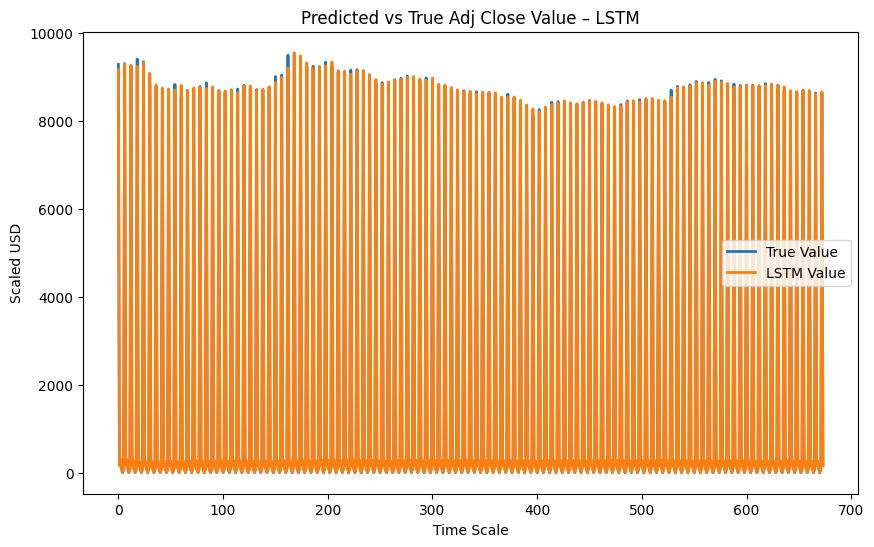

In [89]:
# Create a DataFrame containing the true and predicted values
data = {"Time Scale": range(len(y_test)), "True Value": y_test, "LSTM Value": y_pred_flat}
df = pd.DataFrame(data)

# Plot using Seaborn's lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Time Scale", y="True Value", label="True Value", linewidth=2)
sns.lineplot(data=df, x="Time Scale", y="LSTM Value", label="LSTM Value", linewidth=2)
plt.title("Predicted vs True Adj Close Value – LSTM")
plt.xlabel("Time Scale")
plt.ylabel("Scaled USD")
plt.legend()
plt.show()

In [90]:
df_test = pd.read_csv("data/test.csv",index_col="Date",parse_dates=True)
dfnew = pd.read_csv("data/train.csv")
dfnew = dfnew[["Open","High","Low","Volume","Company","Date"]]
test_data = df_test.merge(dfnew,on="Company")
test_data
test_data.sort_values("Date",inplace=True)
final_pred= lstm.predict(test_data)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
#Process the data for LSTM
test_data
# testX =np.array(X_test)
# X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

ValueError: cannot reshape array of size 26968 into shape (6742,1,1)